## Building model
### Libraries

In [17]:
# Supress warnings
import warnings
warnings.filterwarnings('ignore')

import os
import matplotlib.pyplot as plt
#import pandas as pd
import seaborn as sns
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from sklearn.model_selection import KFold

### Loading datasets

In [18]:
actions = np.array(['adios', 'amor', 'animal',
                    'bienvenida', 'gracias', 'hola', 
                    'hombre', 'internet', 'mujer',
                    'nino_na', 'objeto', 'persona',
                    'radio', 'television', 'tristeza'])

In [19]:
data_folder='dataset/full_data'

X=np.load(os.path.join(data_folder, 'X.npy'))
y=np.load(os.path.join(data_folder, 'y.npy'))

### Build and Train LSTM Neural Network

In [4]:
log_dir=os.path.join('Logs/log_pt10_noes')
tb_callback=TensorBoard(log_dir=log_dir)

In [20]:
# Build the LSTM model
model=Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [21]:
# Summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 64)            442112    
                                                                 
 lstm_4 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 15)                495       
                                                                 
Total params: 597071 (2.28 MB)
Trainable params: 59707

In [22]:
# Define los parámetros para la validación cruzada
seed=42
k=5  # Número de folds
kf=KFold(n_splits=k, shuffle=True, random_state=seed)


In [23]:
# Compile the model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [24]:
# Definir listas para almacenar las métricas de entrenamiento y validación
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [25]:
# Iterar sobre los folds
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Entrena el modelo en este fold
    history = model.fit(X_train, y_train, epochs=1500, batch_size=32, verbose=0, validation_data=(X_val, y_val))
    
    # Almacena las métricas de entrenamiento y validación
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    train_accuracies.append(history.history['categorical_accuracy'])
    val_accuracies.append(history.history['val_categorical_accuracy'])

In [26]:
# Calcular las métricas promedio
avg_train_loss = np.mean(train_losses, axis=0)
avg_val_loss = np.mean(val_losses, axis=0)
avg_train_accuracy = np.mean(train_accuracies, axis=0)
avg_val_accuracy = np.mean(val_accuracies, axis=0)

In [27]:
print(f"Average Train loss: {np.round(np.mean(avg_train_loss), 4)}")
print(f"Average Validation loss: {np.round(np.mean(avg_val_loss), 4)}")
print(f"Average Train accuracy: {np.round(np.mean(avg_train_accuracy), 4)}")
print(f"Average Validation accuracy: {np.round(np.mean(avg_val_accuracy), 4)}")

Average Train loss: 3.3894
Average Validation loss: 21.2243
Average Train accuracy: 0.4909
Average Validation accuracy: 0.434


In [9]:
%load_ext tensorboard
%tensorboard --logdir=./Logs

Reusing TensorBoard on port 6006 (pid 21412), started 8:04:15 ago. (Use '!kill 21412' to kill it.)

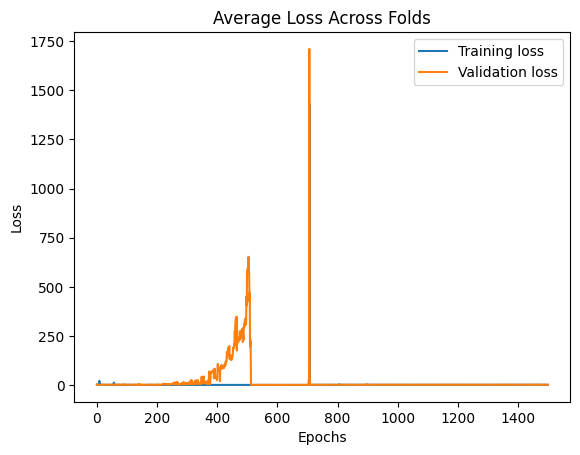

In [28]:
# Graficar la pérdida promedio
plt.plot(avg_train_loss, label='Training loss')
plt.plot(avg_val_loss, label='Validation loss')
plt.title('Average Loss Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

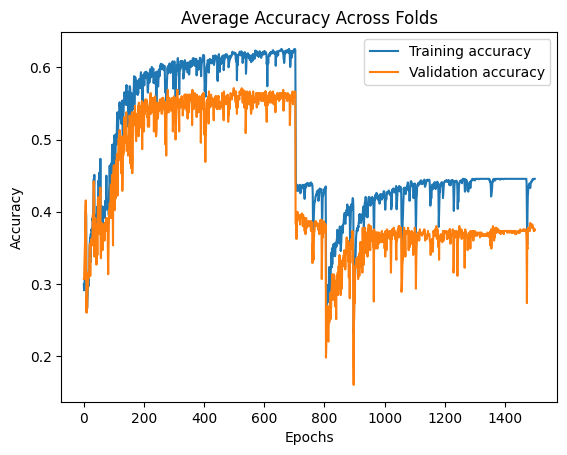

In [29]:
# Graficar la precisión promedio
plt.plot(avg_train_accuracy, label='Training accuracy')
plt.plot(avg_val_accuracy, label='Validation accuracy')
plt.title('Average Accuracy Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Make Predictions

In [9]:
res=model.predict(X_val)

5/5 [==============================] - 1s 39ms/step


In [10]:
actions[np.argmax(res[0])]

'objeto'

In [11]:
actions[np.argmax(y_val[0])]

'animal'

## Save Weights
### Saving model

In [53]:
# Check if the directory 'models' already exists
if not os.path.exists("models"):
    os.makedirs("models")

In [54]:
# Saving the model
model.save("models/sl_model_ver1.h5")

### Loading model

In [15]:
# Path to the model file
model_path="models/sl_model_ver1.h5"

In [16]:
# Load the model
model=load_model(model_path)

In [17]:
# Check the structure model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 15)                495       
                                                                 
Total params: 597071 (2.28 MB)
Trainable params: 597071 

In [18]:
model.load_weights(model_path)

### Evaluation using Confusion Matrix and Accuracy

In [12]:
ypred=model.predict(X_val)

5/5 [==============================] - 0s 46ms/step


In [13]:
ytrue=np.argmax(y_val, axis=1)
ypred=np.argmax(ypred, axis=1)

In [14]:
# Calcular la matriz de confusión multilabel
confusion_matrix=multilabel_confusion_matrix(ytrue, ypred)
confusion_matrix

array([[[128,   0],
        [  7,   0]],

       [[121,   0],
        [ 14,   0]],

       [[123,   0],
        [ 12,   0]],

       [[129,   0],
        [  6,   0]],

       [[129,   0],
        [  6,   0]],

       [[126,   0],
        [  9,   0]],

       [[123,   0],
        [ 12,   0]],

       [[124,   0],
        [ 11,   0]],

       [[125,   0],
        [ 10,   0]],

       [[125,   0],
        [ 10,   0]],

       [[  0, 131],
        [  0,   4]],

       [[125,   0],
        [ 10,   0]],

       [[130,   0],
        [  5,   0]],

       [[127,   0],
        [  8,   0]],

       [[124,   0],
        [ 11,   0]]], dtype=int64)

In [15]:
len(confusion_matrix)

15

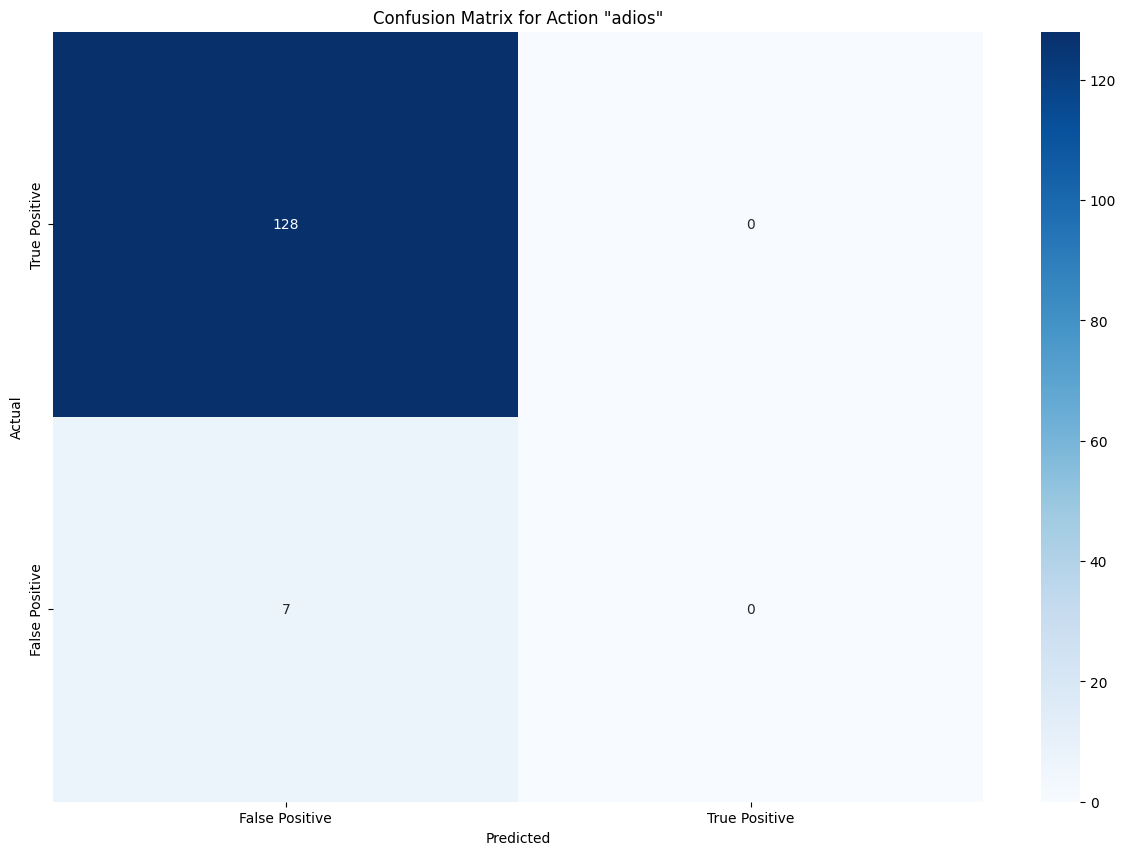

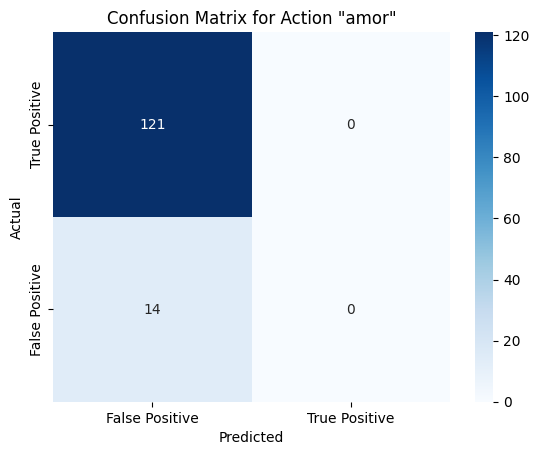

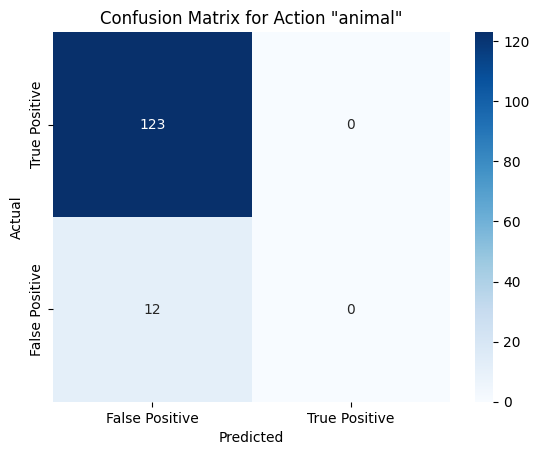

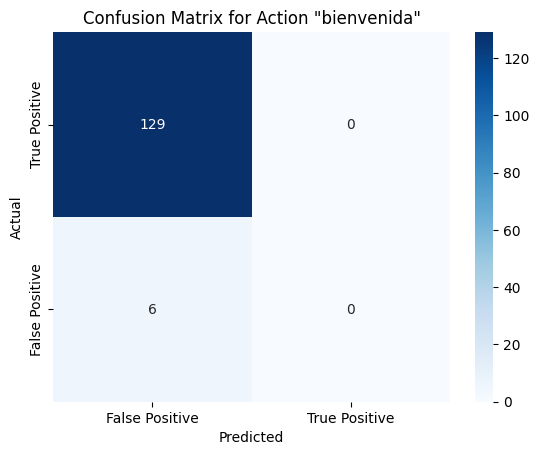

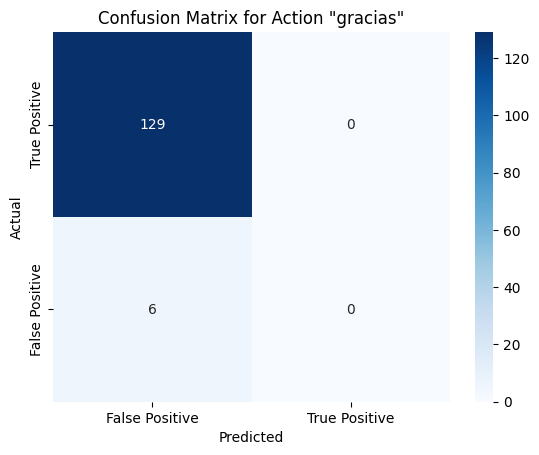

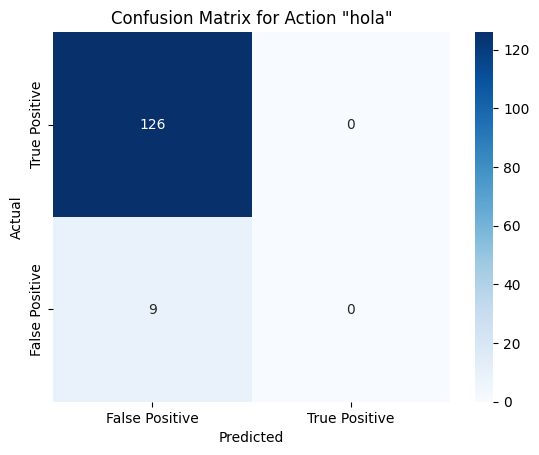

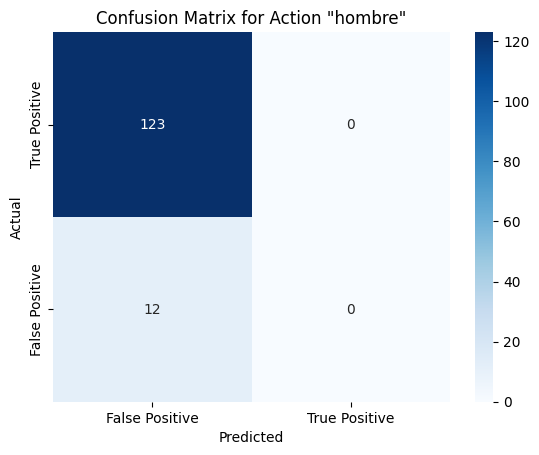

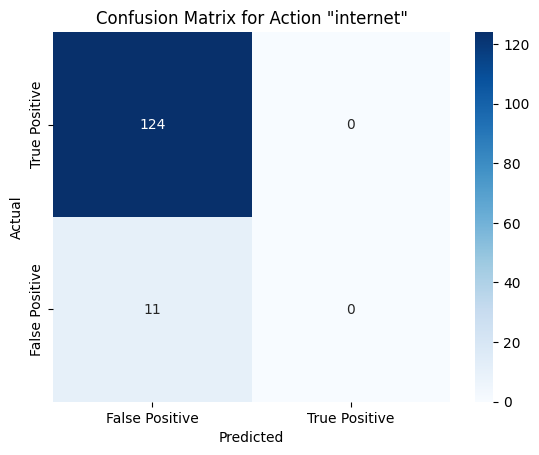

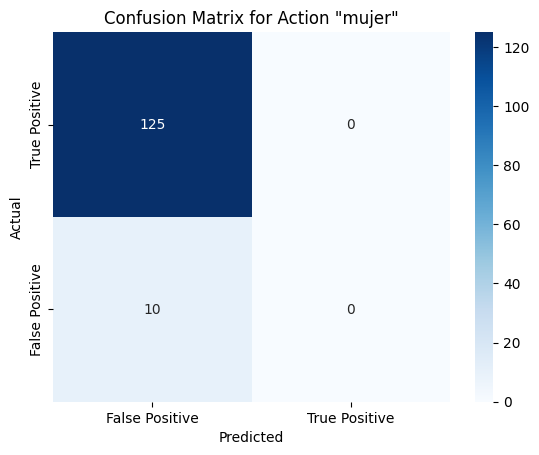

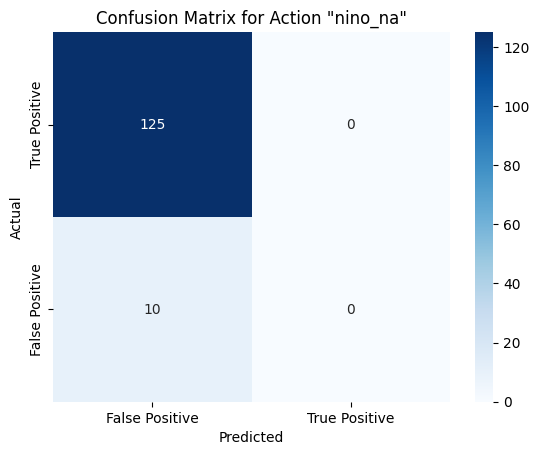

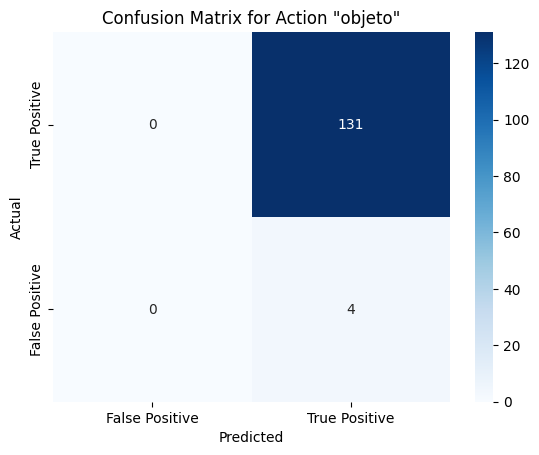

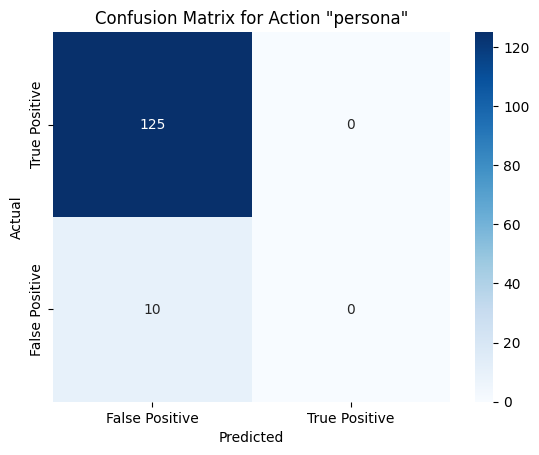

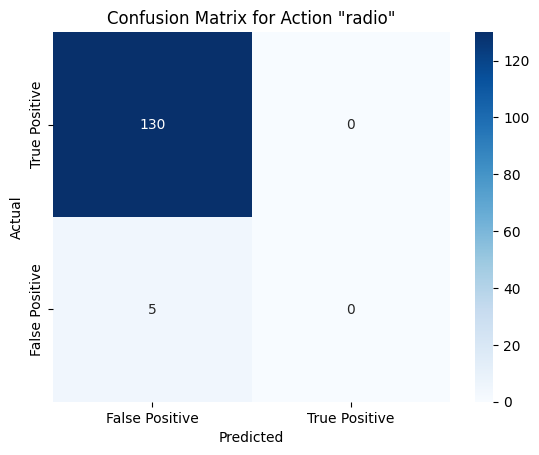

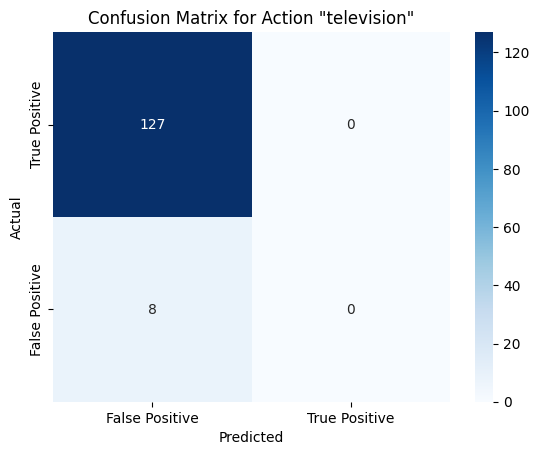

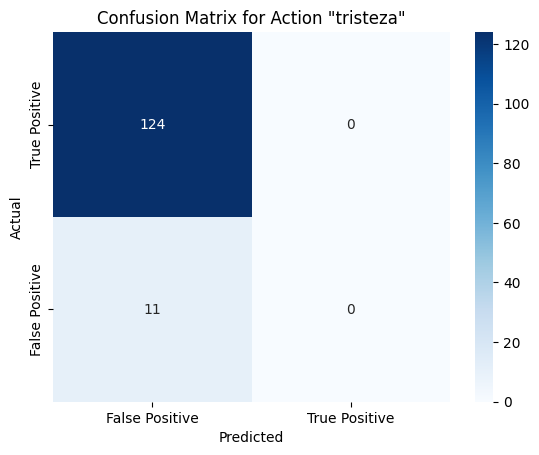

In [16]:
# Visualización usando Seaborn
plt.figure(figsize=(15, 10))
for i in range(len(confusion_matrix)):
    # Verificar si hay alguna predicción para esta acción
    if np.any(np.array([ytrue == i, ypred == i]).T):
        sns.heatmap(confusion_matrix[i], annot=True, fmt='.0f', cmap='Blues', 
                    xticklabels=['False Positive', 'True Positive'],
                    yticklabels=['True Positive', 'False Positive'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix for Action "{actions[i]}"')
        plt.show()

In [17]:
ytrue = np.argmax(y_val, axis=1).tolist()
ypred = model.predict(X_val)
ypred = np.argmax(ypred, axis=1).tolist()
accuracy_score(ytrue, ypred)

5/5 [==============================] - 0s 45ms/step


0.02962962962962963